## LSTM Auto-Encoder-Decoder for Anomaly Detection: 

## Detect anomalous points on time series data of cpu utilization

In [1]:
import numpy as np
import pandas as pd

from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(23)

### Read Data for Cpu utilization, we want to reconstruct the time series using LSTM based Auto-Encoder

In [3]:
df = pd.read_csv('df_merged.csv', parse_dates=['days'], index_col='days')

In [4]:
df.sample(5)

,dt,cur_time_in_gmt,cpu_utilization_pctg,hour,cpu_utilization_pctg_extrapolated,is_extrapolated
days,,,,,,
2017-07-21 01:00:00,7/20/2017,7/21/2017 1:00,50.833,1,50.833,False
2017-04-06 21:00:00,4/6/2017,4/6/2017 21:00,48.611,21,48.611,False
2017-05-12 21:00:00,5/12/2017,5/12/2017 21:00,58.889,21,58.889,False
2017-04-17 07:00:00,4/17/2017,4/17/2017 7:00,26.382,7,26.382,False
2017-04-04 07:00:00,4/4/2017,4/4/2017 7:00,34.167,7,34.167,False


**We collect cpu usage data per hour eveyday, so there are 24 readings per day**

In [5]:
df = df[['cpu_utilization_pctg_extrapolated']]
df.columns = ['cpu_util_pctg']
df.sample(5)

,cpu_util_pctg
days,
2017-04-15 03:00:00,61.066
2017-06-10 20:00:00,46.125
2017-07-06 03:00:00,55.833
2017-05-26 08:00:00,31.389
2017-05-02 23:00:00,33.629


In [6]:
from sklearn.preprocessing import StandardScaler

# Normalize the  data (center around 0 and scale to remove the variance).
scaler = StandardScaler()
df['cpu_util_pctg'] = scaler.fit_transform(df['cpu_util_pctg'].values.reshape(-1, 1))

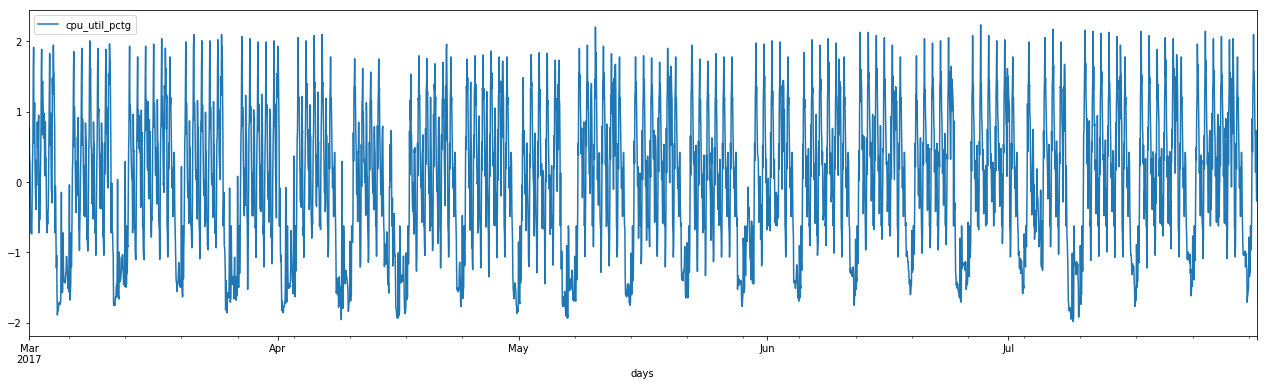

In [7]:
df.plot(figsize=(22,6));

In [8]:
len(df)

3672

In [9]:
df['cpu_util_pctg'] = df['cpu_util_pctg'] / 100

### Create the training, validation and test sets

In [10]:
signal_train = df['2017-03-01':'2017-05-31'].values # March to May
signal_valid = df['2017-06-01':'2017-06-30'].values # June
signal_test = df['2017-07-01':'2017-07-31'].values # July

**Prepare Training Sequences: Create windows of 48 data points each**

In [11]:
window_length = 12 # Why 48? 24 readings in a day, so took for 2 days

In [12]:
train_windows = []

In [13]:
for window_start in range(0, len(signal_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_train[window_range])
    train_windows.append(window)

In [14]:
len(train_windows)

2197

In [15]:
len(signal_test)

744

In [16]:
#x_train = np.expand_dims(np.array(train_windows), axis=2)
#x_train.shape

In [17]:
x_train = np.array(train_windows)
x_train.shape

(2197, 12, 1)

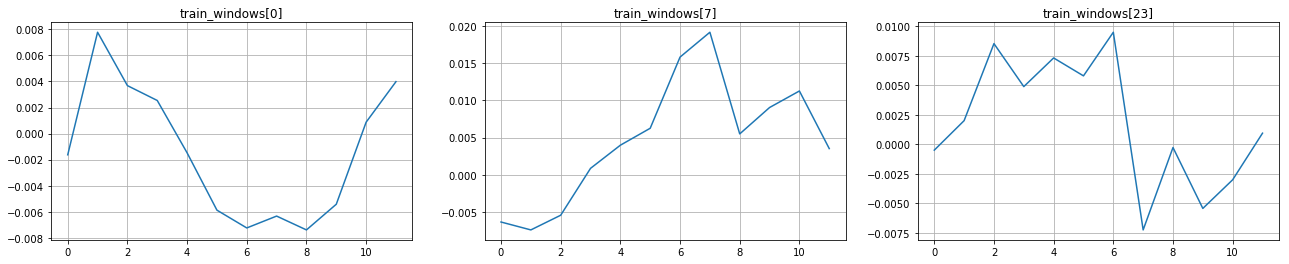

In [18]:
# Visualize the training sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(train_windows[0])
plt.title('train_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(train_windows[7])
plt.title('train_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(train_windows[23])
plt.title('train_windows[23]')
plt.grid(True)
plt.show();

**Prepare Validation Sequences: Create windows of 48 data points each**

In [19]:
valid_windows = []

In [20]:
for window_start in range(0, len(signal_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_valid[window_range])
    valid_windows.append(window)

In [21]:
#x_valid = np.expand_dims(np.array(valid_windows), axis=2)
#x_valid.shape

In [22]:
x_valid = np.array(valid_windows)
x_valid.shape

(709, 12, 1)

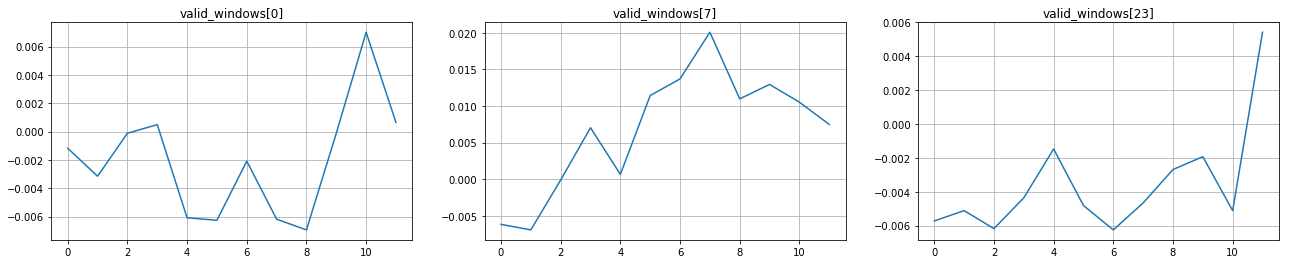

In [23]:
# Visualize the validation sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(valid_windows[0])
plt.title('valid_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(valid_windows[7])
plt.title('valid_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(valid_windows[23])
plt.title('valid_windows[23]')
plt.grid(True)
plt.show();

### Create the LSTM Auto-Encoder Model

In [24]:
input_length = window_length
input_dim = 1
hidden_dim = 12
batch_size = 48 # batch of 7 days of data, 24 readings/day x 7 days
epochs = 50

In [25]:
def mode11():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='linear'))
    return m

In [26]:
def model2():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='sigmoid'))
    m.add(Activation('linear'))
    #m.add(Dense(1, activation='linear'))
    #try with Dense no activation
    #m.add(Dense(1))
    return m

In [27]:
def model3():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    #try with Dense no activation
    m.add(Dense(1))
    return m

In [28]:
def model4():
    m = Sequential()
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(GRU(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    #m.add(Dense(1, activation='linear'))
    m.add(Dense(1))
    return m

In [29]:
#m = model1()
#m = model2()
m = model3()
#m = model3()

In [30]:
m.compile(loss='mse', optimizer='adam')

In [31]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 24)            2496      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 24)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 12)            1776      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 12)            1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 24)            3552      
__________

In [32]:
checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
tbCallBack = TensorBoard(log_dir='./lstm.autoencoder.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

In [33]:
history = m.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, x_valid), callbacks=[checkpointer, earlystopper, tbCallBack]).history

Train on 2197 samples, validate on 709 samples
Epoch 1/50
2197/2197 [==============================] - 5s - loss: 1.0341e-04 - val_loss: 9.0307e-05
Epoch 2/50
2197/2197 [==============================] - 5s - loss: 1.0209e-04 - val_loss: 9.1411e-05
Epoch 3/50
2197/2197 [==============================] - 4s - loss: 1.0069e-04 - val_loss: 9.1616e-05
Epoch 4/50
2197/2197 [==============================] - 4s - loss: 9.4481e-05 - val_loss: 7.9812e-05
Epoch 5/50
2197/2197 [==============================] - 4s - loss: 8.7529e-05 - val_loss: 7.5110e-05
Epoch 6/50
2197/2197 [==============================] - 4s - loss: 8.4164e-05 - val_loss: 7.1771e-05
Epoch 7/50
2197/2197 [==============================] - 4s - loss: 8.2645e-05 - val_loss: 7.1423e-05
Epoch 8/50
2197/2197 [==============================] - 4s - loss: 8.0087e-05 - val_loss: 6.7488e-05
Epoch 9/50
2197/2197 [==============================] - 4s - loss: 8.0208e-05 - val_loss: 6.7480e-05
Epoch 10/50
2197/2197 [=====================

2197/2197 [==============================] - 5s - loss: 2.1847e-05 - val_loss: 7.6661e-06
Epoch 32/50
2197/2197 [==============================] - 4s - loss: 2.2170e-05 - val_loss: 1.0300e-05
Epoch 33/50
2197/2197 [==============================] - 4s - loss: 2.1646e-05 - val_loss: 7.8276e-06
Epoch 34/50
2197/2197 [==============================] - 4s - loss: 2.1067e-05 - val_loss: 7.9404e-06
Epoch 35/50
2197/2197 [==============================] - 4s - loss: 2.0536e-05 - val_loss: 8.0671e-06
Epoch 36/50
2197/2197 [==============================] - 4s - loss: 2.0547e-05 - val_loss: 6.8867e-06
Epoch 37/50
2197/2197 [==============================] - 4s - loss: 1.9505e-05 - val_loss: 7.3179e-06
Epoch 38/50
2197/2197 [==============================] - 4s - loss: 1.9212e-05 - val_loss: 6.4523e-06
Epoch 39/50
2197/2197 [==============================] - 4s - loss: 1.9103e-05 - val_loss: 6.8057e-06
Epoch 40/50
2197/2197 [==============================] - 4s - loss: 1.8898e-05 - val_loss: 5.4

In [34]:
#model_file = 'auto-encoder-anom.h5'
#m.save(model_file)

In [35]:
pred_x_valid = m.predict(x_valid)

### Visualize the reconstruction on the validation set (select random sets)

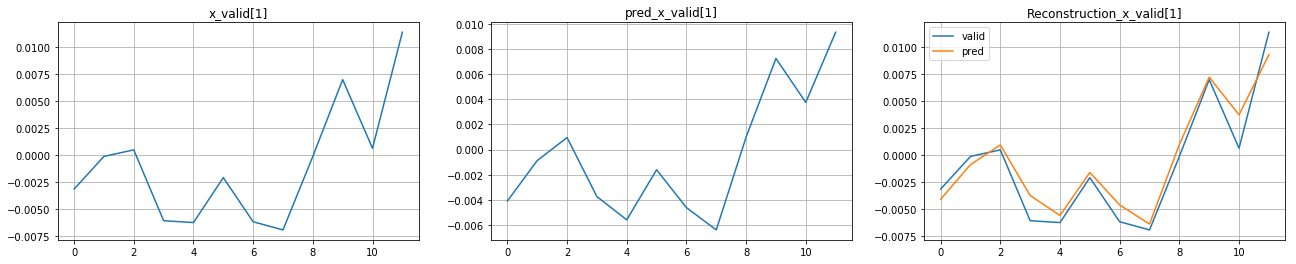

In [36]:
# Visualize the reconstruction on validation sequence[1]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[1])
plt.title('x_valid[1]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[1])
plt.title('pred_x_valid[1]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[1], label='valid')
plt.plot(pred_x_valid[1], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[1]')
plt.grid(True)
plt.show();

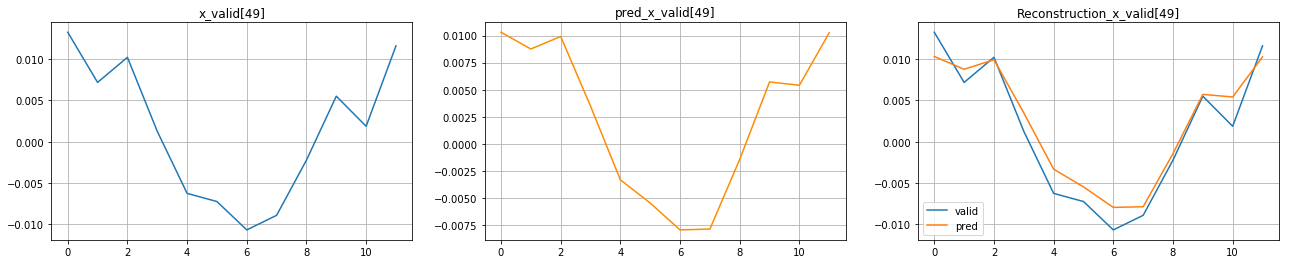

In [37]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[49])
plt.title('x_valid[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[49], color='darkorange')
plt.title('pred_x_valid[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[49], label='valid')
plt.plot(pred_x_valid[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[49]')
plt.grid(True)
plt.show();

### Summarise Model Loss Over Training Epochs

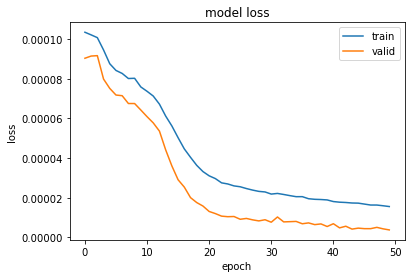

In [38]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

In [39]:
signal_test[201]

array([-0.01148523])

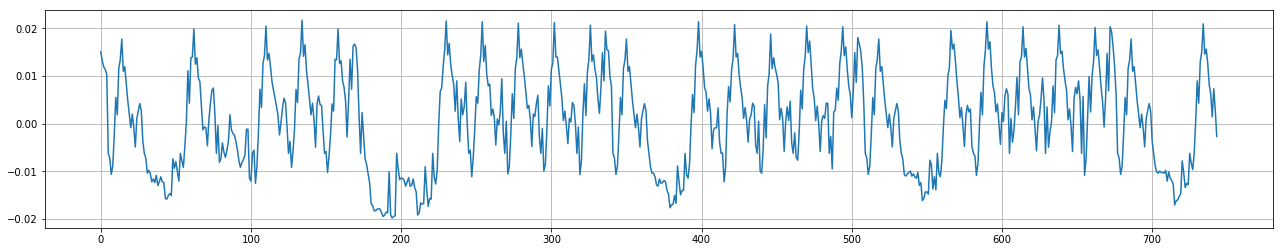

In [40]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.grid(True)

### Simulate Anomalies on the test set (select random points)

In [41]:
simulated_signal_test = np.copy(signal_test)

In [42]:
random_indices = [201, 422] # random points chosen
simulated_signal_test[random_indices]

array([[-0.01148523],
       [ 0.02081718]])

In [43]:
# switching over values to crete anomaly
simulated_signal_test[201] = 0.02081718 # 0.81
simulated_signal_test[422] = -0.01148523 # 0.35

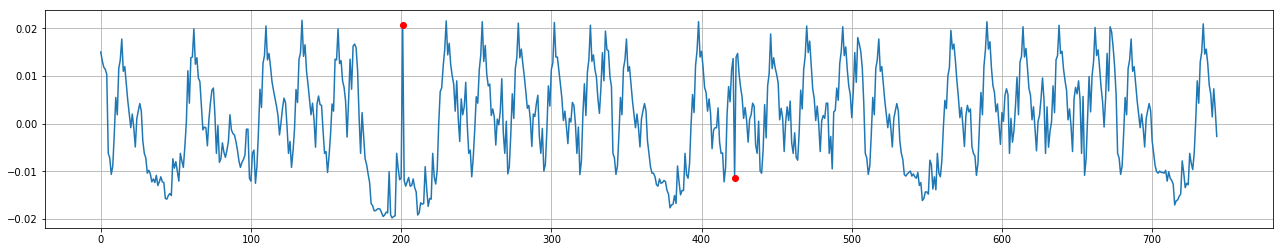

In [44]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
plt.grid(True)

**Prepare Test Sequences: Create windows of 48 data points each**

In [45]:
test_windows = []
contain_outliers= []

In [46]:
for window_start in range(0, len(simulated_signal_test) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(simulated_signal_test[window_range])
    is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    contain_outliers.append(is_outlier)
    test_windows.append(window)

In [47]:
x_test = np.array(test_windows)
x_test.shape

(733, 12, 1)

In [48]:
pred_x_test = m.predict(x_test)

### Visualize the reconstruction on the simulated test set (select random sets)

In [49]:
outlier_indices = np.where(contain_outliers)[0]

In [50]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422])

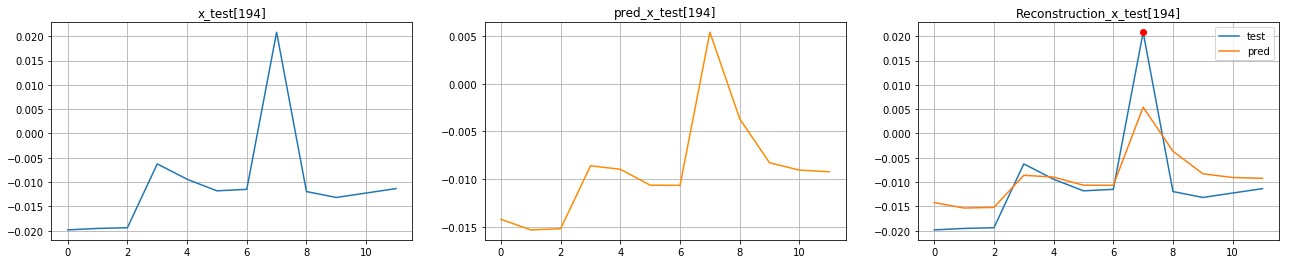

In [51]:
# Visualize the reconstruction on a random test sequence
left = random_indices[0]
choose = outlier_indices[4]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[choose])
plt.title('x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[choose], color='darkorange')
plt.title('pred_x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[choose], label='test')
plt.plot(pred_x_test[choose], label='pred')
plt.plot(left - choose, x_test[choose][left-choose], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[{0}]'.format(choose))
plt.grid(True)
plt.show();

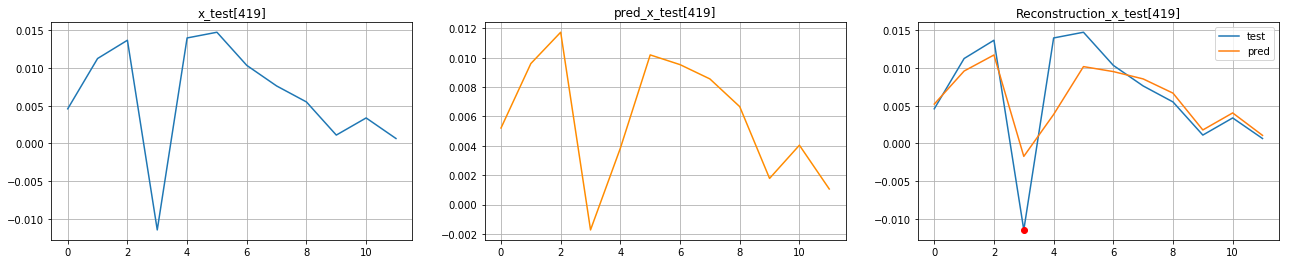

In [52]:
# Visualize the reconstruction on a random test sequence
left = random_indices[1]
choose = outlier_indices[-4]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[choose])
plt.title('x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[choose], color='darkorange')
plt.title('pred_x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[choose], label='test')
plt.plot(pred_x_test[choose], label='pred')
plt.plot(left - choose, x_test[choose][left-choose], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[{0}]'.format(choose))
plt.grid(True)
plt.show();

In [53]:
max_mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test[1:] - x_test[1:]), axis=1))
#max_mae_of_predictions

In [54]:
avg_mae_of_predictions = np.squeeze(np.mean(np.square(pred_x_test[1:] - x_test[1:]), axis=1))
#avg_mae_of_predictions

In [55]:
df = pd.DataFrame(data=np.c_[max_mae_of_predictions, avg_mae_of_predictions], columns=['max_mae_of_predictions', 'avg_mae_of_predictions'])
df.sample(3)

,max_mae_of_predictions,avg_mae_of_predictions
136,0.000003,0.000002
337,0.000028,0.000007
486,0.000028,0.000006


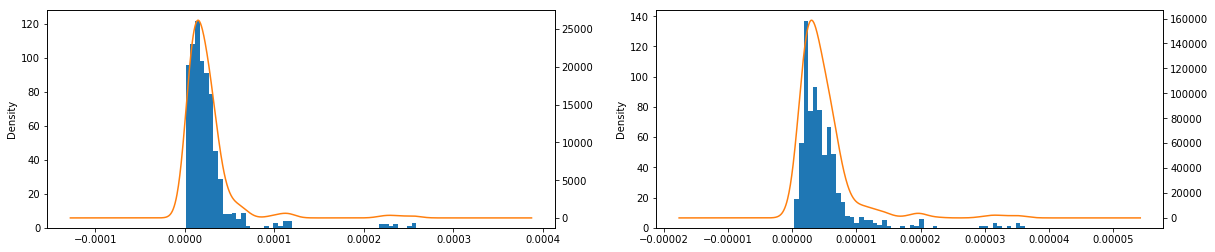

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
df['max_mae_of_predictions'].plot.hist(bins=50, ax=ax[0])
df['max_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[0])
df['avg_mae_of_predictions'].plot.hist(bins=50, ax=ax[1])
df['avg_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[1]);

In [57]:
from scipy import stats
kernel_max_mae = stats.gaussian_kde(df['max_mae_of_predictions'].values)
kernel_avg_mae = stats.gaussian_kde(df['avg_mae_of_predictions'].values)

In [58]:
df['pdf_max_mae'] = df['max_mae_of_predictions'].map(lambda x: kernel_max_mae.integrate_box(x - 1e-8, x + 1e-8))
df['pdf_avg_mae'] = df['avg_mae_of_predictions'].map(lambda x: kernel_avg_mae.integrate_box(x - 1e-8, x + 1e-8))

In [60]:
# Top anomalous points by max_mae
df.nlargest(10, columns=['pdf_max_mae'])

,max_mae_of_predictions,avg_mae_of_predictions,pdf_max_mae,pdf_avg_mae
642,0.000015,0.000004,0.000524,0.003074
716,0.000015,0.000003,0.000524,0.003150
641,0.000015,0.000003,0.000524,0.003172
144,0.000015,0.000003,0.000524,0.003143
143,0.000015,0.000003,0.000524,0.003167
145,0.000015,0.000003,0.000524,0.003149
436,0.000015,0.000004,0.000524,0.003041
170,0.000015,0.000005,0.000524,0.002272
310,0.000014,0.000002,0.000523,0.003077
309,0.000014,0.000002,0.000523,0.003047


In [62]:
# Top anomalous points by avg_mae
df.nlargest(10, columns=['pdf_avg_mae'])

,max_mae_of_predictions,avg_mae_of_predictions,pdf_max_mae,pdf_avg_mae
43,0.000014,0.000003,0.000523,0.003173
87,0.000026,0.000003,0.000420,0.003173
384,0.000009,0.000003,0.000477,0.003173
576,0.000012,0.000003,0.000510,0.003173
439,0.000018,0.000003,0.000514,0.003173
444,0.000023,0.000003,0.000453,0.003173
591,0.000030,0.000003,0.000354,0.003173
240,0.000010,0.000003,0.000499,0.003173
255,0.000024,0.000003,0.000439,0.003173
241,0.000010,0.000003,0.000498,0.003172


In [63]:
max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)  # can use a running mean instead.
max_mae_threshold

5.6602202241208085e-05

In [64]:
pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
pred_outlier_indices

array([109, 133, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 229, 253, 277, 301, 325, 397, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 469, 589, 637, 660, 661, 662, 663,
       664, 665, 666])

In [65]:
len(pred_outlier_indices)

42

In [66]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422])

In [67]:
len(outlier_indices)

24

In [68]:
set(outlier_indices).intersection(set(pred_outlier_indices))

{190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421}

**Metrics**

In [69]:
tp = len(set(outlier_indices).intersection(set(pred_outlier_indices)))

In [70]:
fn = len(set(outlier_indices) - set(pred_outlier_indices))

In [71]:
fp = len(set(pred_outlier_indices) - set(outlier_indices))

In [72]:
all_indices = set(range(len(x_test))) 
tn = len((all_indices - set(outlier_indices)).intersection(all_indices - set(pred_outlier_indices)))

In [73]:
precision = float(tp) / (tp + fp)

In [74]:
hit_rate = float(tp) / (tp + fn)

In [75]:
accuracy = float(tp + tn) / (tp + tn + fp + fn)

In [76]:
print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 0.5238095238095238, hit_rate = 0.9166666666666666, accuracy = 0.9699863574351978
